## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [1]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

d:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
d:\Anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
d:\Anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior 

In [2]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [3]:
# file_name = "BTC-USD.csv"
# file_name = "s_000002.csv"
file_name = "s_000004.csv"
data = preprocess.load_data(file_name)
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1991-01-02,16.78,16.78,16.78,16.78,115
1,1991-01-10,16.22,16.22,16.22,16.22,5
2,1991-01-14,15.98,15.98,15.98,15.98,5


In [4]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.8, plot_df=True)

Starting with data preparation...
Completed.


In [5]:
train_df.shape, test_df.shape

((5896, 7), (1474, 7))

### Explore the Data

In [6]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

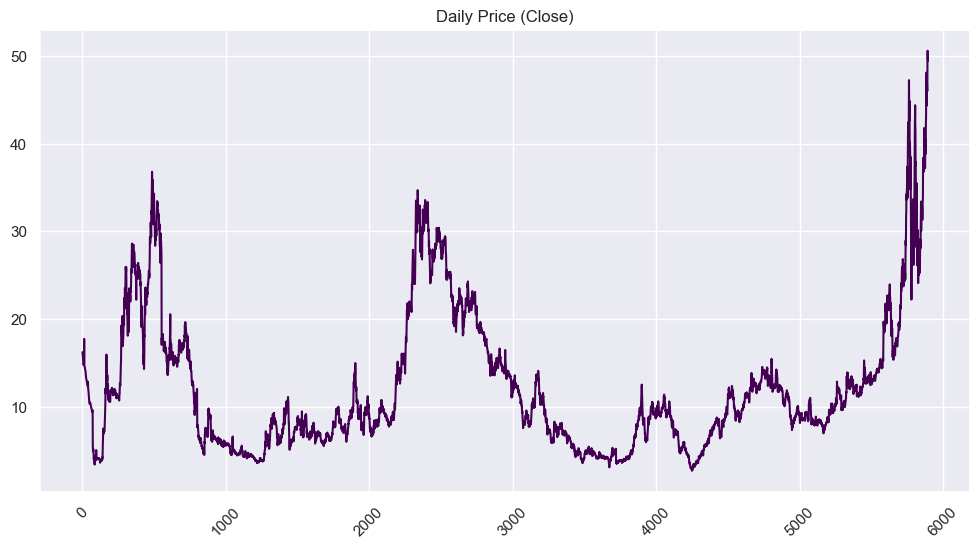

In [7]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

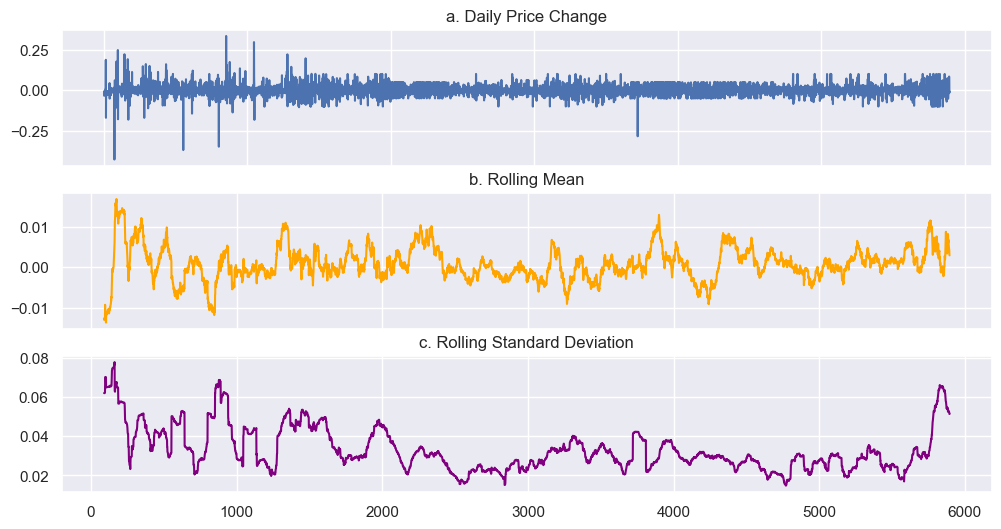

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [9]:
sequence_length = 30
step = 1
batch_size = 8
n_epochs = 50
n_epochs_stop = 10
label_name = 'Close'

In [10]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, step, batch_size, n_epochs, n_epochs_stop)

Starting with model training...


dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


Epoch 1 train loss: 0.008 test loss: 0.0564
Epoch 2 train loss: 0.0112 test loss: 0.0918
Epoch 3 train loss: 0.012 test loss: 0.0621
Epoch 4 train loss: 0.0096 test loss: 0.0471
Epoch 5 train loss: 0.0066 test loss: 0.0324
Epoch 6 train loss: 0.0048 test loss: 0.0241
Epoch 7 train loss: 0.0039 test loss: 0.0197
Epoch 8 train loss: 0.0035 test loss: 0.0169
Epoch 9 train loss: 0.0033 test loss: 0.015
Epoch 10 train loss: 0.0031 test loss: 0.0135
Epoch 11 train loss: 0.0029 test loss: 0.0124
Epoch 12 train loss: 0.0027 test loss: 0.0114
Epoch 13 train loss: 0.0026 test loss: 0.0107
Epoch 14 train loss: 0.0025 test loss: 0.01
Epoch 15 train loss: 0.0024 test loss: 0.0095
Epoch 16 train loss: 0.0023 test loss: 0.009
Epoch 17 train loss: 0.0023 test loss: 0.0085
Epoch 18 train loss: 0.0022 test loss: 0.0081
Epoch 19 train loss: 0.0021 test loss: 0.0077
Epoch 20 train loss: 0.0021 test loss: 0.0072
Epoch 21 train loss: 0.002 test loss: 0.0071
Epoch 22 train loss: 0.0019 test loss: 0.0078
Epoc

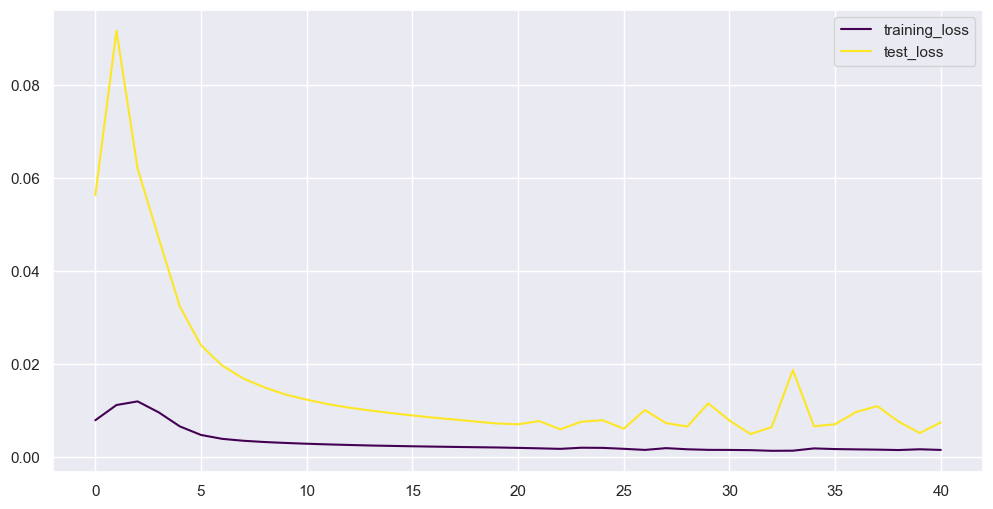

In [11]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the LSTM + Attention model

In [12]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


((1443,), (1443,))

In [13]:

pred_lens = [24, 48, 168, 336, 720]
for pred_len in pred_lens:
    if pred_len > len(predictions_descaled):
        break
    print('Error on partial test data with pred_len: ', pred_len)
    inference.print_loss_metrics(labels_descaled[:pred_len], predictions_descaled[:pred_len])

Error on partial test data with pred_len:  24
RMSE:  1.72
MAE:  1.39
Error on partial test data with pred_len:  48
RMSE:  2.5
MAE:  1.99
Error on partial test data with pred_len:  168
RMSE:  2.98
MAE:  2.43
Error on partial test data with pred_len:  336
RMSE:  2.52
MAE:  2.02
Error on partial test data with pred_len:  720
RMSE:  1.96
MAE:  1.51


In [14]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  3.38
MAE:  2.52


Error on partial test data:
RMSE:  2.32
MAE:  1.78


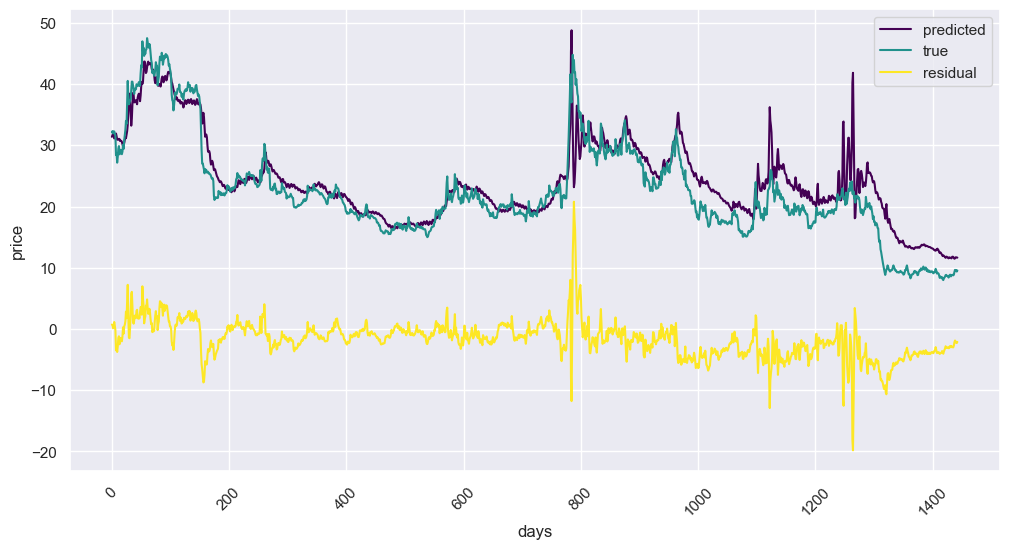

In [15]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [16]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [17]:
background_data_size = 900
test_sample_size = 100
# sequence_length = 50

In [18]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [19]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i- sequence_length -1 for i in list(range(1, sequence_length + 1))]
shap_plot.head()

,Close,Volume,High_Low_Pct,Open_Close_Pct,Day_Of_Week,Month_Of_Year,Quarter_Of_Year,days
0,0.009587,0.001033,0.000017,0.000010,0.000988,0.000466,0.000291,-30
1,0.009643,0.001014,0.000011,0.000011,0.000969,0.000487,0.000277,-29
2,0.009826,0.001001,0.000016,0.000012,0.000933,0.000474,0.000321,-28
3,0.010100,0.001035,0.000022,0.000013,0.000956,0.000460,0.000367,-27
4,0.010276,0.001083,0.000021,0.000013,0.001013,0.000475,0.000366,-26


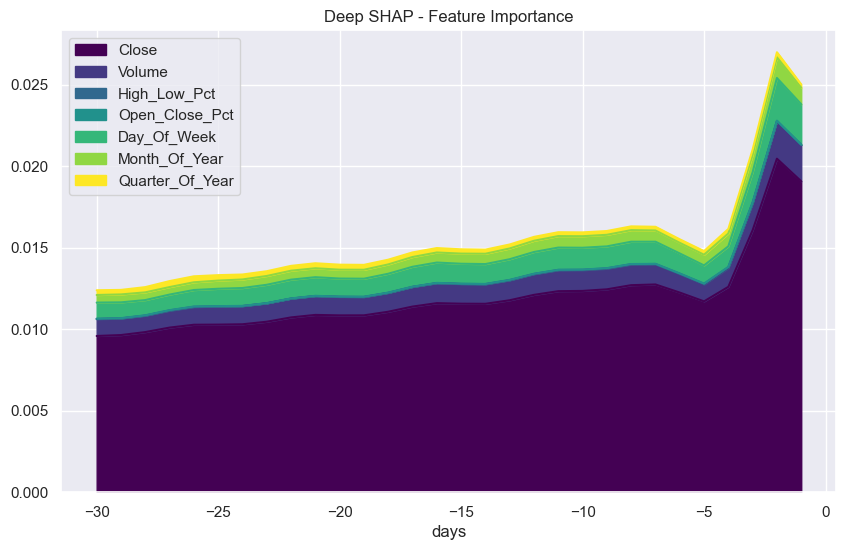

In [20]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()

In [21]:
train_df = preprocess.load_data('train.csv')
shap.summary_plot(shap_values[0], plot_type = 'bar')

AssertionError: Summary plots need a matrix of shap_values, not a vector.